In [2]:
#downloading the dataset 
!wget https://raw.githubusercontent.com/kamalkraj/DATA-SCIENCE-BOWL-2018/master/data/stage1_train.zip
!wget https://raw.githubusercontent.com/kamalkraj/DATA-SCIENCE-BOWL-2018/master/data/stage1_test.zip
!unzip stage1_test -d /content/stage1_test
!unzip stage1_train -d /content/stage1_train

Streaming output truncated to the last 5000 lines.
  inflating: /content/stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/160cf18b03df69978e2ed33335afcd781ebebf4ee42df566aaa6fd0aee66ac93.png  
  inflating: /content/stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/16d3bf2426e9cda0e4f435de3a0c260d17be460f1c834c1282dfd68f9fcf7509.png  
  inflating: /content/stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1cfe69ef1dec8963e05ba8386a956af0073ba0bec2cc8ba534df81ef6dee905a.png  
  inflating: /content/stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/1d2543cd2a8134ac2ca091a230bd15270826f8dd83c6594550b7f0fc85a15f8e.png  
  inflating: /content/stage1_train/d35f25c8e3f7fca5232fc4d5e3faf14b025b20b3731af77fe971a5e2e9d69d28/masks/24b50e6e3406e513d47ddfa9bd85505a95a266858cffc730a9ad7bc99936b800.png  
  inflating: /content/stage1_train/d35f25c8e3f7fca5232fc4d5e3faf

In [3]:
import tensorflow as tf
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   # the progress bar
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        # mask = np.maximum(mask, mask_)  
        mask = mask + mask_ 
        mask[mask>1] = 1
            
    Y_train[n] = mask   
    
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img



print('Done!')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Resizing training images and masks


  0%|          | 0/670 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 670/670 [06:08<00:00,  1.82it/s]


Resizing test images


100%|██████████| 65/65 [00:01<00:00, 35.46it/s]

Done!


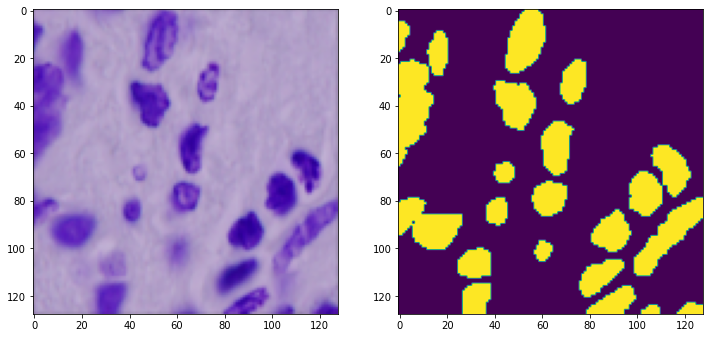

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


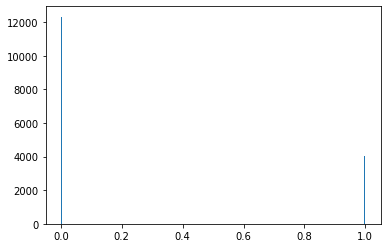

In [6]:
#sanity check to check if the images and their corresponding masks are matching
image_number = random.randint(0, len(train_ids))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(np.squeeze(Y_train[image_number]))


plt.show() 
ptyhf= Y_train[image_number]
plt.hist(ptyhf.ravel(), 256,[0,1]); plt.show() #to make sure the data is normalized

In [ ]:
# the model - standardad U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) #integers (8-bit) to flouting, since the input layer only accepts floating points

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 17s 81ms/step - loss: 0.6078 - accuracy: 0.7964 - val_loss: 0.4296 - val_accuracy: 0.8154
Epoch 2/25
38/38 [==============================] - 1s 39ms/step - loss: 0.3291 - accuracy: 0.8493 - val_loss: 0.2537 - val_accuracy: 0.8977
Epoch 3/25
38/38 [==============================] - 2s 40ms/step - loss: 0.1916 - accuracy: 0.9255 - val_loss: 0.1591 - val_accuracy: 0.9370
Epoch 4/25
38/38 [==============================] - 1s 39ms/step - loss: 0.1412 - accuracy: 0.9456 - val_loss: 0.1386 - val_accuracy: 0.9446
Epoch 5/25
38/38 [==============================] - 2s 40ms/step - loss: 0.1236 - accuracy: 0.9533 - val_loss: 0.1182 - val_accuracy: 0.9575
Epoch 6/25
38/38 [==============================] - 2s 40ms/step - loss: 0.1149 - accuracy: 0.9562 - val_loss: 0.1162 - val_accuracy: 0.9572
Epoch 7/25
38/38 [==============================] - 2s 40ms/step - loss: 0.1103 - accuracy: 0.9584 - val_loss: 0.1009 - val_accuracy: 0.9618
Epoch 8/25
3

In [ ]:

####################################

idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



3/3 [==============================] - 0s 146ms/step


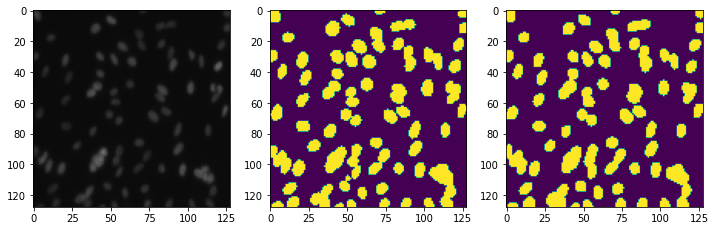

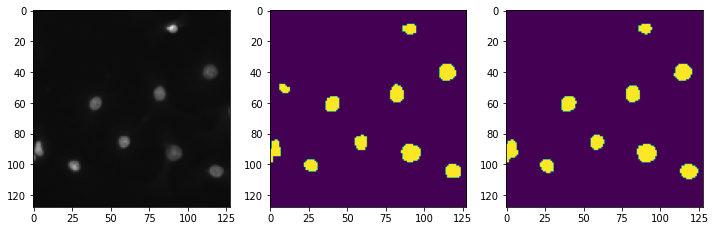

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(X_train[ix])
plt.subplot(132)
plt.imshow(np.squeeze(Y_train[ix]))
plt.subplot(133)
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.show()
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.subplot(132)
plt.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.subplot(133)
plt.imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [ ]:
!tensorboard --logdir=logs/ --host localhost --port 8088



NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.8.0 at http://localhost:8088/ (Press CTRL+C to quit)
